# 基于经典网络架构训练图像分类模型
## 使用的模型是resnet152,图像分类的类别是102
### 数据预处理部分：

- 数据增强：torchvision中的transforms模块自带功能，比较实用
- 数据预处理：torchvision中的transforms实现好的
- DataLoader模块直接读取batch数据

### 网络模块设置：
- 加载预训练模型，这里我们使用的是resnet152，用起来很方便，直接使用别人训练好的模型权重参数来继续训练，也就是所谓的迁移学习
- 修改最后的全连接层，因为任务的输出不同，我们要将全连接层的输出神经元改为符合我们任务的个数即102
- 训练时可以全部重头训练，也可以只训练最后咱们任务的层，因为前几层都是做特征提取的，本质任务目标是一致的

### 网络模型的保存与测试
- 模型保存的时候可以带有选择性，例如在验证集中如果当前效果好则保存
- 读取模型进行实际测试

In [2]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

# ----------------------训练模型-----------------------

# 处理数据集

## 数据读取、数据增强、数据预处理

In [6]:
# 数据存储路径
data_dir = './flower_data/'
train_dir = data_dir + 'train'
valid_dir = data_dir + 'valid'

# data_transforms中指定了所有图像预处理操作
data_transforms = {
  'train': transforms.Compose([transforms.RandomRotation(45),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomGrayscale(p=0.025),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 制作数据集，数据加载器
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','valid']} # 训练和测试数据集
batch_size = 6
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=batch_size,shuffle=True) for x in ['train','valid']} # 训练和测试集加载器
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [7]:
# 查看样本数，和类别数
print(dataset_sizes,len(class_names))

{'train': 6552, 'valid': 818} 102


In [8]:
# 查看数据集
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: ./flower_data/train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=[0.8, 1.2], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: ./flower_data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456,

In [9]:
# 读取标签对应的实际名字
with open('cat_to_name.json','r') as f:
    cat_to_name = json.load(f)

cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

### 展示下数据图片

In [10]:
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

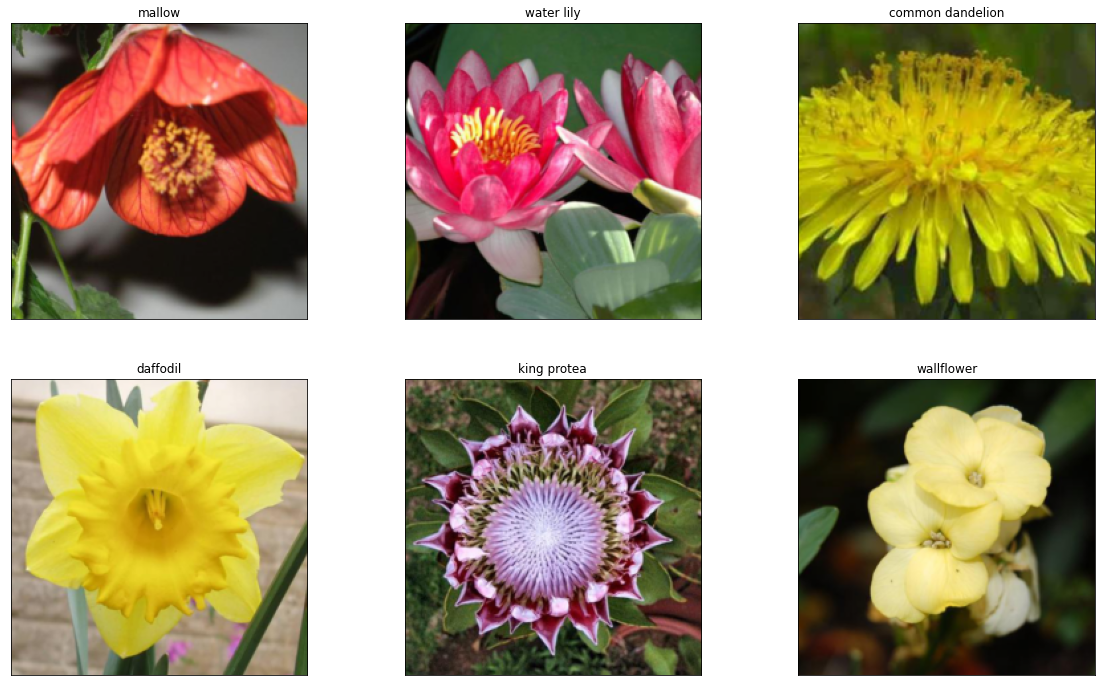

In [12]:
fig=plt.figure(figsize=(20, 12))
columns = 3
rows = 2

dataiter = iter(dataloaders['valid'])
inputs, classes = dataiter.next()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

# 网络模块设置

In [13]:
# 查看模型框架
model = models.resnet152()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# 使用模型的预训练参数，不做更新
def set_parameter_requires_grad(model,feature_extract):
    if feature_extract: # 为True
        for param in model.parameters():
            param.requires_grad = False # 不更新权重参数

In [15]:
def initialize_model(num_calsses,feature_extract,model_name='resnet152',use_pretrained=True):
    # 初始化模型,修改最后一层的结构
    # 模型名字，类别数，直接使用参数不发生变化，使用模型的参数
    # 获得模型
    resnet152 = models.resnet152(pretrained=use_pretrained)
    set_parameter_requires_grad(resnet152,feature_extract) # 调用上面定义好的函数
    num_features = resnet152.fc.in_features # 2048
    # 修改最后一层的线形层 因为我们要做的是102分类
    resnet152.fc = nn.Sequential(nn.Linear(num_features,num_calsses),nn.LogSoftmax(dim=1))
    input_size = 224 # 要求图片的维度为224*224
    return resnet152,input_size


In [16]:
# 设置哪些层需要训练
model_name = 'resnet152'
num_classes = 102
feature_extract = True
# 获取模型
model,input_size = initialize_model(num_classes,feature_extract,model_name=model_name,use_pretrained=True)

# GPU计算
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 模型保存的路径
filename = 'checkpoint.pth'

# 是否训练所有层
params_to_update = model.parameters()
print('Params to learn:')
if feature_extract: # 只训练后面的全连接层
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print('\t',name)
else: # 全部训练
    for name,param in model.named_parameters():
        if parm.requires_grad == True:
            print('\t',name)
# 从结果可以看出，我们只训练了最后的全连接层

Params to learn:
	 fc.0.weight
	 fc.0.bias


In [17]:
# 修改完网络架构后，再查看一下网络的架构，可以看到最后一层发生了变化
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 优化器设置和损失函数设置

In [18]:
## 优化器设置
from torch import optim
optimizer = optim.Adam(params_to_update,lr=1e-2) # params_to_update：模型需要更新的参数
# 学习率每7个epoch衰减成原来的1/10
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
# 损失函数 最后一层已经是LogSoftmax,所有不能用nn.CrossEntropyLoss
criterion = nn.NLLLoss()

## 训练模块

In [21]:
from tqdm import tqdm

In [26]:
def train_model(model,dataloaders,criterion,optimizer,
                num_epochs=5,is_inception=False,filename=filename):
    since = time.time() # 模型训练的起始时间
    best_acc = 0 # 存储最好的准确率值
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc]
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """

    model.to(device)
    train_acc_history = []
    val_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict()) # best_model_wts：存储模型最好的那次权重参数

    # 开始训练
    for epoch in range(num_epochs):
        print(f'Epoch{epoch}/{num_epochs-1}')
        print('-'*10)

        # 训练集和验证集
        for phase in ['train','valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # 把数据取个遍
            for inputs,labels in tqdm(dataloaders[phase],total = len(dataloaders[phase]), position = 0, leave = True):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 梯度清零
                optimizer.zero_grad()
                # 只有训练时更新梯度
                with torch.set_grad_enabled(phase=='train'):
                    if is_inception and phase == 'train':
                        outputs,aux_outputs = model(inputs)
                        loss1 = criterion(outputs,labels)
                        loss2 = criterion(aux_outputs,labels)
                        loss = loss1+0.4*loss2
                    else: # resnet执行的是这里
                        outputs = model(inputs) # 输出
                        loss = criterion(outputs,labels) # 损失
                    _,preds = torch.max(outputs,1) # 获得预测标签值

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0) # 一次epoch所有样本的总损失
                # 计算预测正确样本数
                running_corrects += torch.sum(preds==labels.data)

            # 计算一次epoch的平均损失和正确率
            epoch_loss = running_loss/len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double()/len(dataloaders[phase].dataset)

            # 打印信息
            time_elapsed = time.time()-since # 从开始训练到现在的训练时长
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
            print('{} Loss:{:.4f} Acc:{:.4f}'.format(phase,epoch_loss,epoch_acc))

            ####### 模型的保存
            # 得到验证时期最好那次的模型,并保存
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc # 得到最大的准确率
                best_model_wts = copy.deepcopy(model.state_dict()) # 得到准确率最大的模型权重参数
                state = {
                    'state_dict':model.state_dict(),
                    'best_acc':best_acc,
                    'optimizer':optimizer.state_dict(), # 优化器的参数即学习率的值也要保存
                }
                torch.save(state,filename) # 保存模型到filename文件内
            
            # 将信息添加到列表中
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        # 打印 每次epoch的信息
        print('Optimizer learning rate:{:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()
    
    # 训练结束，打印总时间和best_acc
    time_elapsed = time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best val Acc:{:4f}'.format(best_acc))

    # 训练完后用最好的一次当作模型最终的结果
    model.load_state_dict(best_model_wts)
    
    return model,val_acc_history,train_acc_history,valid_losses,train_losses,LRs

## 开始训练！

In [27]:
model,val_acc_history,train_acc_history,valid_losses,train_losses,LRs = train_model(model,dataloaders,criterion,optimizer,num_epochs=5,is_inception=False,filename=filename)

Epoch0/4
----------


100%|██████████| 1092/1092 [02:28<00:00,  7.37it/s]


Time elapsed 2m 28s
train Loss:10.3956 Acc:0.5176


100%|██████████| 137/137 [00:11<00:00, 11.48it/s]


Time elapsed 2m 40s
valid Loss:15.7619 Acc:0.4670


/data/home/zhujianling/anaconda3/envs/python3.8/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Optimizer learning rate:0.0001000

Epoch1/4
----------


100%|██████████| 1092/1092 [02:42<00:00,  6.74it/s]


Time elapsed 5m 23s
train Loss:6.1314 Acc:0.6542


100%|██████████| 137/137 [00:15<00:00,  9.00it/s]


Time elapsed 5m 39s
valid Loss:8.0268 Acc:0.6125
Optimizer learning rate:0.0010000

Epoch2/4
----------


100%|██████████| 1092/1092 [02:36<00:00,  6.96it/s]


Time elapsed 8m 17s
train Loss:3.2813 Acc:0.7399


100%|██████████| 137/137 [00:14<00:00,  9.60it/s]


Time elapsed 8m 32s
valid Loss:6.0253 Acc:0.6699
Optimizer learning rate:0.0100000

Epoch3/4
----------


100%|██████████| 1092/1092 [02:36<00:00,  6.96it/s]


Time elapsed 11m 11s
train Loss:11.4771 Acc:0.5316


100%|██████████| 137/137 [00:12<00:00, 11.39it/s]


Time elapsed 11m 23s
valid Loss:17.2352 Acc:0.5086
Optimizer learning rate:0.0001000

Epoch4/4
----------


100%|██████████| 1092/1092 [02:31<00:00,  7.19it/s]


Time elapsed 13m 54s
train Loss:6.3068 Acc:0.6769


100%|██████████| 137/137 [00:11<00:00, 11.45it/s]

Time elapsed 14m 6s
valid Loss:8.4424 Acc:0.6430
Optimizer learning rate:0.0010000

Training complete in 14m 6s
Best val Acc:0.669927


- 上面训练加载器的batches = 1092 ,因为 batch_size=6, 总样本数为6552，6552/6=1092
- 上面验证加载器的batches = 137 ,因为batch_size = 6,总样本数位818，137*6=822

In [30]:
print('train_acc_history:',train_acc_history)
print('val_acc_history:',val_acc_history)
print('train_losses:',train_losses)
print('valid_losses:',valid_losses)

train_acc_history: [tensor(0.5176, device='cuda:0', dtype=torch.float64), tensor(0.6542, device='cuda:0', dtype=torch.float64), tensor(0.7399, device='cuda:0', dtype=torch.float64), tensor(0.5316, device='cuda:0', dtype=torch.float64), tensor(0.6769, device='cuda:0', dtype=torch.float64)]
val_acc_history: [tensor(0.4670, device='cuda:0', dtype=torch.float64), tensor(0.6125, device='cuda:0', dtype=torch.float64), tensor(0.6699, device='cuda:0', dtype=torch.float64), tensor(0.5086, device='cuda:0', dtype=torch.float64), tensor(0.6430, device='cuda:0', dtype=torch.float64)]
train_losses: [10.395630008343055, 6.131395776910217, 3.281283918068638, 11.477076506771505, 6.30680377955174]
valid_losses: [15.761945307036193, 8.02676378054262, 6.02530526339983, 17.235208131000057, 8.442415635417932]


# --------------------------------训练模型结束--------------------------

# ----------------------------测试模型--------------------------------
## ---------------------------对数据作预测----------------------------

# 读取保存好的模型

In [31]:
## 该代码可不执行
# 如果不懂，可以参考train_model函数中的模型保存部分
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc'] # 获取best_acc
model.load_state_dict(checkpoint['state_dict']) # 给模型设置验证时期的最好权重参数
optimizer.load_state_dict(checkpoint['optimizer'])

In [32]:
print(best_acc)

tensor(0.6699, device='cuda:0', dtype=torch.float64)


# 预测!!!

## 预测---加载训练好的模型

In [33]:
# 1.加载训练好的模型
model,input_size = initialize_model(102,feature_extract,model_name='resnet152',use_pretrained=True)

# GPU模式
model = model.to(device)

# 保存文件的名字
filename = 'checkpoint.pth'

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

## 预测--测试数据预处理
- 测试数据处理的方法需要跟训练时一样才可以
- crop的操作的目的是保证输入的大小是一致的标准化操作也是必须的，用跟训练数据相应的mean和std，但是需要注意一点训练数据是在0-1上进行标准化，所以测试数据也需要先归一化
- 最后一点，pytorch中颜色通道是第一个维度，跟很多工具不一样，需要转换

In [37]:
def process_image(image_path):
    # 读取测试数据
    img = Image.open(image_path)
    #Resize,thumbnail方法只能进行缩小，所以进行了判断
    if img.size[0] > img.size[1]:
        img.thumbnail((10000,256))
    else:
        img.thumbnail((256,10000))
    # Crop操作
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin+224
    top_margin = bottom_margin+224
    img = img.crop((left_margin,bottom_margin,right_margin,top_margin))
    # 相同的预处理方法
    img = np.array(img)/255
    mean = np.array([0.485,0.456,0.406]) # 归一化 全为0-1之间
    std = np.array([0.229,0.224,0.225]) # 标准化
    img = (img-mean)/std
    # 注意颜色通道应该放在第一个位置
    img = img.transpose(2,0,1)

    return img

In [38]:
def imshow(image,ax=None,title=None):
    """ 展示 """
    if ax is None:
        fig,ax = plt.subplots()
    
    # 颜色通道还原
    image = np.array(image).transpose((1,2,0))

    # 预处理还原
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.set_title(title)
    
    return ax

<AxesSubplot:>

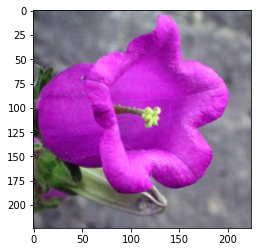

In [39]:
image_path = 'image_06621.jpg'
img = process_image(image_path) # 数据预处理
imshow(img) # 图片展示

In [40]:
img.shape

(3, 224, 224)

## 对一个batch数据进行预测

In [42]:
# 对一个batch数据进行预测
dataiter = iter(dataloaders['valid'])
images,labels = next(dataiter)

model.eval()

if torch.cuda.is_available(): # 测试
    output = model(images.cuda())
else:
    output = model(images)

print('output.shape:',output.shape)
print('labels.shape:',labels.shape)

output.shape: torch.Size([6, 102])
labels.shape: torch.Size([6])


In [60]:
# 对输出结果得到概率最大的那个
_,pred = torch.max(output,dim=1)
# 将pred转化为numpy数据
pred = np.squeeze(pred.numpy()) if not torch.cuda.is_available() else np.squeeze(pred.cpu().numpy())
pred

array([17, 11, 77, 12, 71, 11])

In [65]:
labels

array([17, 11, 77, 12,  2, 11])

### 计算准确率

In [68]:
# 计算准确率
correct_num = np.sum(pred==labels) # 5
acc_rate = correct_num/len(labels)
print(acc_rate.item(),correct_num)

0.8333333333333334 5


### 展示预测结果

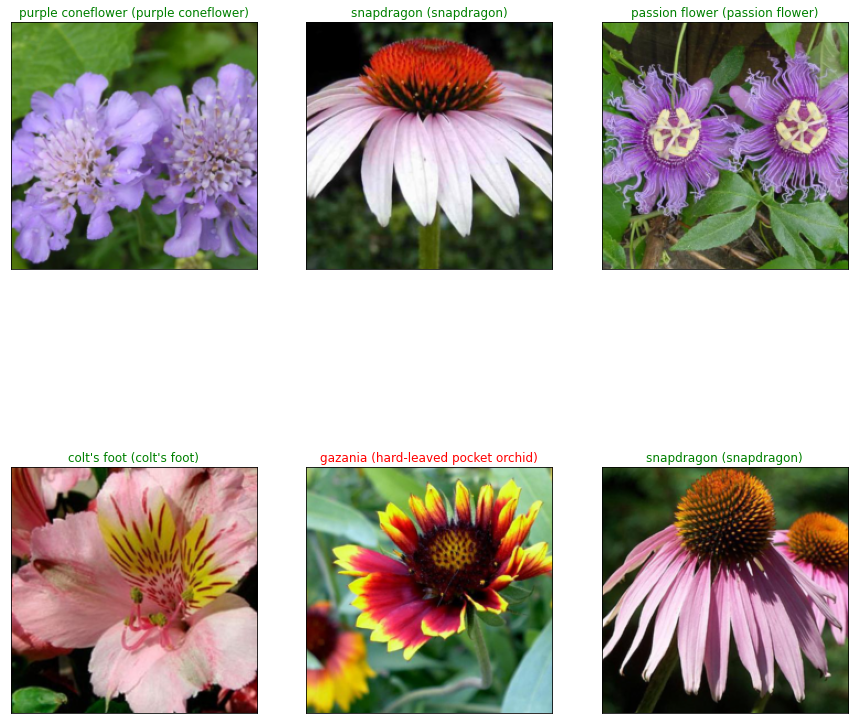

In [70]:
fig = plt.figure(figsize=(15,15))
columns = 3
rows = 2

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(cat_to_name[str(pred[idx])], cat_to_name[str(labels[idx].item())]),
                 color=("green" if cat_to_name[str(pred[idx])]==cat_to_name[str(labels[idx].item())] else "red"))
plt.show()